# Assignment 4: Wheres Waldo?
### Name: Eileanor LaRocco
In this assignment, you will develop an object detection algorithm to locate Waldo in a set of images. You will develop a model to detect the bounding box around Waldo. Your final task is to submit your predictions on Kaggle for evaluation.

### Process/Issues
- Double-checked that the images we were given were correctly bounded (did this by visualizing the boxes on the images - they look good!)
- Complication: Originally when I creating augmented images, the bounding box labels did not also augment. I also had to try out a few types of augmentation to see what made sense for waldo. The augmented images may still not be as different from one another as they could be which could allow the model to favor the training images that occur more frequently.
- Complication: Similarly, when resizing the images, ensuring the bounding boxes not only are also adjusted if necessary, but ensuring they do not get cut off and the image is not stretched/shrunk too much.
- Tried Yolo architecture first but produced too many boxes and did not work well. Tried faster rcnn architecture next and the inputs and outputs and processing steps for each were very different which was frustrating

### Imports

In [1]:
import os
import opendatasets as od
import pandas as pd
import numpy as np
import random
import csv
import matplotlib.pyplot as plt

import shutil
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import DataLoader
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image

In [2]:
SEED = 1

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = device = torch.device("mps")
print(device)

mps


### Paths

In [23]:
train_folder = "2024-fall-ml-3-hw-4-wheres-waldo/train/train" # Original Train Images
test_folder = "2024-fall-ml-3-hw-4-wheres-waldo/test/test" # Original Test Images
annotations_file = "2024-fall-ml-3-hw-4-wheres-waldo/annotations.csv" # Original Annotations File
image_sz = 512

In [24]:
# Define the dataset (Train and Test Loaders)
class WaldoDataset(torch.utils.data.Dataset):
    def __init__(self, annotations_file, img_dir, transforms=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")
        #image = torchvision.transforms.ToTensor()(image)  # Convert to tensor
        
        box_data = self.img_labels.iloc[idx, 1:].values
        boxes = [float(item) for item in box_data]
        
        boxes = torch.as_tensor([boxes], dtype=torch.float32)
        labels = torch.ones((1,), dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((1,), dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            image = self.transforms(image)

        return image, target


# Set up the dataset and data loaders
train_dataset = WaldoDataset(
    annotations_file="2024-fall-ml-3-hw-4-wheres-waldo/train_annotations.csv",
    img_dir="2024-fall-ml-3-hw-4-wheres-waldo/train/chunks",
    transforms=torchvision.transforms.Compose([
        #torchvision.transforms.Resize((image_sz, image_sz)), #does this resize the bounding box too?
        torchvision.transforms.ToTensor()
    ])
)

val_dataset = WaldoDataset(
    annotations_file="2024-fall-ml-3-hw-4-wheres-waldo/test_annotations.csv",
    img_dir="2024-fall-ml-3-hw-4-wheres-waldo/train/val",
    transforms=torchvision.transforms.Compose([
        #torchvision.transforms.Resize((image_sz, image_sz)),
        torchvision.transforms.ToTensor()
    ])
)

train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=lambda x: list(zip(*x))  # Fix the collate_fn to return a list of images and targets
)

val_data_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    collate_fn=lambda x: list(zip(*x))  # Same here for validation
)


# Model

In [32]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
model = fasterrcnn_resnet50_fpn(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /Users/elarocco/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)>

### Architecture

In [25]:
# Define the model
class ImprovedBBoxModel(nn.Module):
    def __init__(self):
        super(ImprovedBBoxModel, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        # Global Average Pooling and Fully Connected Layers
        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, 4)  # (x, y, w, h)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        bbox = self.fc2(x)
        return bbox


# Example usage:
model = ImprovedBBoxModel()

# Input a batch of 128x128 RGB images (batch_size=2)
images = torch.randn(2, 3, image_sz, image_sz)  # Random images for demonstration

# Forward pass
output = model(images)
print("Bounding box predictions: ", output)


Bounding box predictions:  tensor([[ 0.1317, -0.0056,  0.0378, -0.0351],
        [ 0.1321, -0.0061,  0.0343, -0.0351]], grad_fn=<AddmmBackward0>)


### Training

In [27]:
def calculate_iou(pred_boxes, target_boxes):
    """
    Compute IoU between predicted and target bounding boxes.
    Args:
        pred_boxes: Tensor of shape (N, 4) with predicted boxes (x_min, y_min, x_max, y_max).
        target_boxes: Tensor of shape (N, 4) with ground truth boxes (x_min, y_min, x_max, y_max).
    Returns:
        IoU: Tensor of shape (N,) with IoU scores for each box.
    """
    # Resize Target Boxes
    target_boxes = target_boxes.squeeze(1)

    # Calculate intersection
    x_min_inter = torch.max(pred_boxes[:, 0], target_boxes[:, 0])
    y_min_inter = torch.max(pred_boxes[:, 1], target_boxes[:, 1])
    x_max_inter = torch.min(pred_boxes[:, 2], target_boxes[:, 2])
    y_max_inter = torch.min(pred_boxes[:, 3], target_boxes[:, 3])

    inter_area = torch.clamp(x_max_inter - x_min_inter, min=0) * torch.clamp(y_max_inter - y_min_inter, min=0)

    # Calculate union
    pred_area = (pred_boxes[:, 2] - pred_boxes[:, 0]) * (pred_boxes[:, 3] - pred_boxes[:, 1])
    target_area = (target_boxes[:, 2] - target_boxes[:, 0]) * (target_boxes[:, 3] - target_boxes[:, 1])
    union_area = pred_area + target_area - inter_area

    # Compute IoU
    iou = inter_area / torch.clamp(union_area, min=1e-6)  # Avoid division by zero
    return iou

# Set up the model, loss, and optimizer
model = ImprovedBBoxModel()#.to(device)
criterion = nn.L1Loss()  # L1 loss for bounding box regression
optimizer = optim.Adam(model.parameters(), lr=0.001)


def train(model, train_data_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        total_iou = 0.0
        num_samples = 0

        for images, targets in train_data_loader:
            # Extract bounding boxes from targets
            target_boxes = torch.stack([target["boxes"] for target in targets]).squeeze(1)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(torch.stack(images))

            # Calculate the loss
            loss = criterion(outputs, target_boxes)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Update running loss
            running_loss += loss.item()

            # Calculate IoU
            iou = calculate_iou(outputs, target_boxes)
            total_iou += iou.sum().item()
            num_samples += len(target_boxes)

        avg_loss = running_loss / len(train_data_loader)
        avg_iou = total_iou / num_samples

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}, IoU: {avg_iou:.4f}")


def evaluate(model, val_data_loader, criterion):
    model.eval()
    total_loss = 0.0
    total_iou = 0.0
    num_samples = 0

    with torch.no_grad():
        for images, targets in val_data_loader:
            # Extract bounding boxes from targets
            target_boxes = torch.stack([target["boxes"] for target in targets]).squeeze(1)

            # Forward pass
            outputs = model(torch.stack(images))

            # Calculate the loss
            loss = criterion(outputs, target_boxes)
            total_loss += loss.item()

            # Calculate IoU
            iou = calculate_iou(outputs, target_boxes)
            total_iou += iou.sum().item()
            num_samples += len(target_boxes)

    avg_loss = total_loss / len(val_data_loader)
    avg_iou = total_iou / num_samples

    print(f"Evaluation Loss: {avg_loss:.4f}, IoU: {avg_iou:.4f}")

# Train the model
train(model, train_data_loader, criterion, optimizer, num_epochs=10)

# Evaluate the model
evaluate(model, val_data_loader, criterion)



Epoch 1/10, Loss: 257.3299, IoU: 0.0000
Epoch 2/10, Loss: 253.0687, IoU: 0.0000
Epoch 3/10, Loss: 243.0720, IoU: 0.0000
Epoch 4/10, Loss: 229.5623, IoU: 0.0000
Epoch 5/10, Loss: 209.8753, IoU: 0.0000
Epoch 6/10, Loss: 191.8661, IoU: 0.0000
Epoch 7/10, Loss: 150.6530, IoU: 0.0005
Epoch 8/10, Loss: 132.5168, IoU: 0.0003
Epoch 9/10, Loss: 122.1744, IoU: 0.0000
Epoch 10/10, Loss: 122.5712, IoU: 0.0000
Evaluation Loss: 125.6696, IoU: 0.0000


# Submission File 

Predicted Bounding Box: [541.12616 410.55585 589.3815  441.67966]


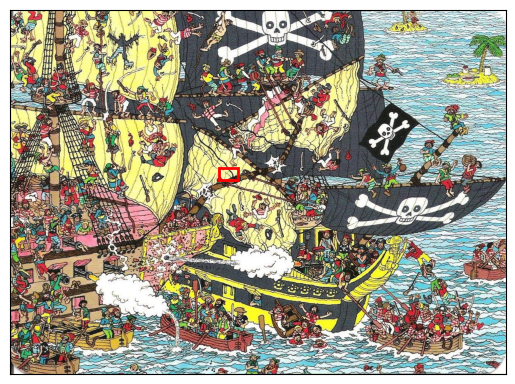

Predicted Bounding Box: [329.08575 244.87912 358.4502  263.47345]


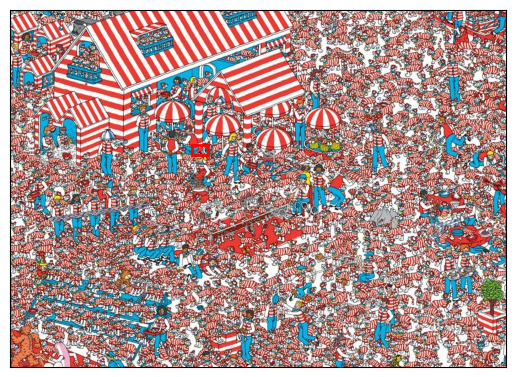

Predicted Bounding Box: [284.21338 213.93918 309.56516 230.15465]


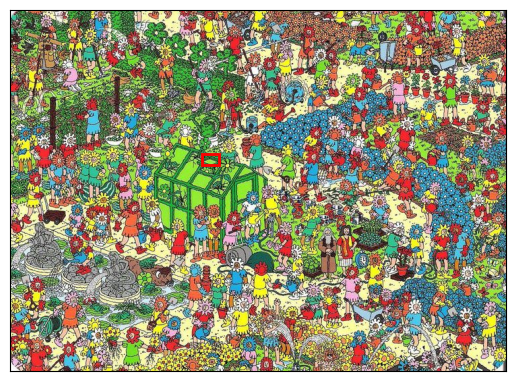

Predicted Bounding Box: [343.9823  261.55725 374.697   281.4667 ]


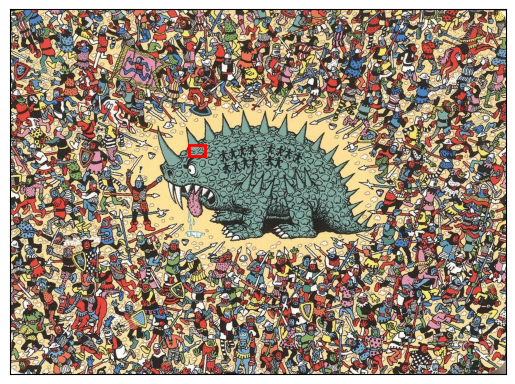

Predicted Bounding Box: [297.52673 335.36923 323.96838 360.3471 ]


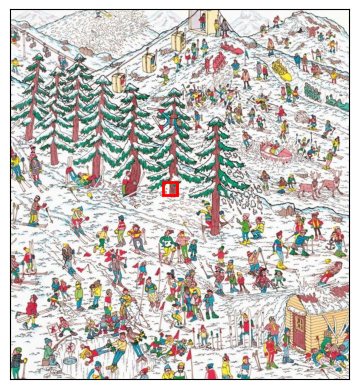

Predicted Bounding Box: [265.7265 274.5673 289.4495 295.4799]


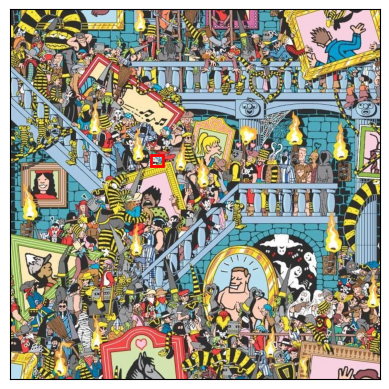

Predicted Bounding Box: [ 979.0618   663.97833 1066.4487   714.46   ]


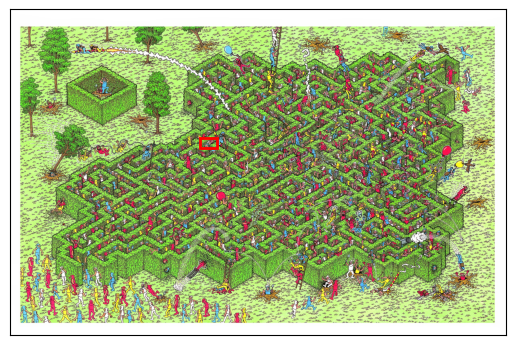

Predicted Bounding Box: [656.7625  426.09592 715.3269  458.30148]


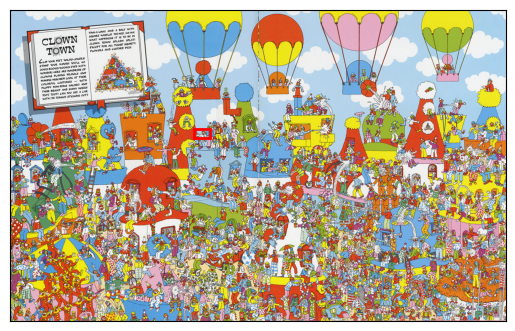

Predicted Bounding Box: [355.27637 256.5508  387.00958 276.13306]


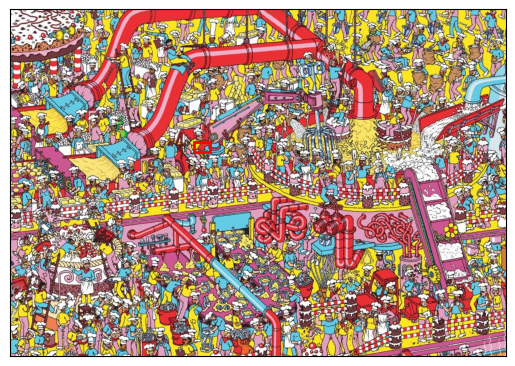

In [28]:
predictions = []

output_directory = "2024-fall-ml-3-hw-4-wheres-waldo/outputs"
if not os.path.exists(output_directory):
        os.makedirs(output_directory)

# Function to predict bounding box on a new image
def predict(model, image_path, transform=None):
    model.eval()  # Set the model to evaluation mode

    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")  # Open image and convert to RGB
    orig_width, orig_height = image.size  # Get original image dimensions
    if transform:
        image = transform(image)  # Apply transformations
    image = image.unsqueeze(0)  # Add batch dimension

    # Predict the bounding box
    with torch.no_grad():
        predicted_bbox = model(image).squeeze().cpu().numpy()

    # Scale bbox back to original image dimensions
    predicted_bbox[0] *= orig_width / image_sz  # x_min
    predicted_bbox[1] *= orig_height / image_sz  # y_min
    predicted_bbox[2] *= orig_width / image_sz  # x_max
    predicted_bbox[3] *= orig_height / image_sz  # y_max

    return predicted_bbox


# Define image transformations (resize, normalization)
transform = transforms.Compose([
    transforms.Resize((image_sz, image_sz)),  # Resize the image to 128x128
    transforms.ToTensor()  # Convert the image to a tensor
])

#For each image in test folder, predict, draw bounding box, save image, and save into csv file for submission
test_images = [img for img in os.listdir(test_folder) if img.endswith(".jpg")]
predictions = []

for name in test_images:
    # Example usage for prediction on a new image
    image_path = os.path.join(test_folder, name)  # Replace with the path to your test image
    predicted_bbox = predict(model, image_path, transform)

    # Print the predicted bounding box (x_min, y_min, x_max, y_max)
    print("Predicted Bounding Box:", predicted_bbox)

    # Plot the image and the predicted bounding box
    image = Image.open(image_path)
    plt.imshow(image)
    plt.gca().add_patch(plt.Rectangle(
        (predicted_bbox[0], predicted_bbox[1]),  # (x_min, y_min)
        predicted_bbox[2] - predicted_bbox[0],  # Width (x_max - x_min)
        predicted_bbox[3] - predicted_bbox[1],  # Height (y_max - y_min)
        linewidth=2, edgecolor='r', facecolor='none'
    ))
    plt.xticks([])
    plt.yticks([])
    plt.savefig(os.path.join(output_directory, name), bbox_inches='tight')
    plt.show()

    # Extract bounding box coordinates
    x_min, y_min, x_max, y_max = predicted_bbox
    predictions.append([name, x_min, y_min, x_max, y_max])

# Save predictions to CSV
df = pd.DataFrame(predictions, columns=["filename", "xmin", "ymin", "xmax", "ymax"])
df.to_csv(os.path.join(output_directory, 'predictions.csv'), index=False)
